<a href="https://colab.research.google.com/github/DarxinZ/ML/blob/main/T10_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

class ITrainable:
    def __init__(self):
        pass

    def forward_propagation(self, prev_A):
        raise NotImplementedError("forward_propagation not implemented: ITrainable is an interface")

    def backward_propagation(self, dA):
        raise NotImplementedError("backward_propagation not implemented: ITrainable is an interface")

    def update_parameters(self):
        raise NotImplementedError("update_parameters not implemented: ITrainable is an interface")

    def save_parameters(self, file_path):
        pass

    def restore_parameters(self, file_path):
        pass

class DLLinearFamily(ITrainable):
    def __init__(self,name, n, alpha, optimization=None):
        self.name = name
        self.alpha = alpha
        self.optimization = optimization
        self.W = np.zeros((n,1),dtype=float)
        self.b = 0
        # optimization parameters
        if self.optimization == 'adaptive':
            self.adaptive_cont = 1.1
            self.adaptive_switch = 0.5
            self.adaptive_W = np.full(self.W.shape,alpha,dtype=float)
            self.adaptive_b = alpha
            
    def __str__(self):
        s = f"{self.name} Function:\n"
        s += f"\tlearning_rate (alpha): {self.alpha}\n"
        if self.optimization != None:
            s += f"\tOptimization: {self.optimization}\n"
            if self.optimization == "adaptive":
                s += f"\t\tadaptive parameters:\n"
                s += f"\t\t\tcont: {self.adaptive_cont}\n"
                s += f"\t\t\tswitch: {self.adaptive_switch}\n"
        s += "\tParameters:\n"
        s += f"\t\tW shape: {self.W.shape}\n"
        s += f"\t\tb: {self.b}\n"
        return s;


    def forward_propagation(self, prev_A):
        self.prev_A = np.copy(prev_A)
        Z = self.W.T@prev_A+self.b
        return Z

    def backward_propagation(self, dZ):
        db_m_values = dZ * np.full((1,self.prev_A.shape[1]),1)
        dW_n_m_values = dZ * self.prev_A
        self.db = np.sum(db_m_values, keepdims=True, axis=1)
        self.dW = np.sum(dW_n_m_values, keepdims=True, axis=1)
    
    def update_parameters(self):
        if self.optimization == 'adaptive':
            self.adaptive_W *= np.where(self.adaptive_W * self.dW > 0, self.adaptive_cont, -self.adaptive_switch)
            self.W -= self.adaptive_W 
            if self.adaptive_b * self.db > 0:
                self.adaptive_b *= self.adaptive_cont
            else:
                self.adaptive_b *= -self.adaptive_switch
            self.b -= self.adaptive_b 
        else:
            self.W -= self.alpha * self.dW
            self.b -= self.alpha * self.db

class DLLinearLayer(ITrainable):
    def __init__(self,name, num_units,input_size, alpha,optimization=None,initialization=None):
        self.name = name
        self.alpha = alpha
        self.num_units = num_units
        self.input_size = input_size
        self.optimization = optimization
        #self.W = np.zeros((n,1),dtype=float)
        self.W = DLLinearLayer.normal_initialization((num_units,input_size), factor=1)

        if initialization == "He":
            self.W = DLLinearLayer.normal_initialization((num_units,input_size), factor=1)
            self.W = DLLinearLayer.W_he_initialization(self)
        elif initialization == "Xavier":
            self.W = DLLinearLayer.normal_initialization((num_units,input_size), factor=1)
            self.W = DLLinearLayer.W_Xaviar_initialization(self)
        else:
            self.W = DLLinearLayer.normal_initialization((num_units,input_size), factor=0.01)

        self.b = np.zeros((num_units,1),dtype=float)
        # optimization parameters
        if self.optimization == 'adaptive':
            self.adaptive_cont = 1.1
            self.adaptive_switch = 0.5
            self.adaptive_W = np.full(self.W.shape,alpha,dtype=float)
            self.adaptive_b = np.full(self.b.shape,alpha,dtype=float)
            #self.adaptive_b = alpha
    
    def __str__(self):
        s = f"{self.name} Function:\n"
        s += f"\tlearning_rate (alpha): {self.alpha}\n"
        if self.optimization != None:
            s += f"\tOptimization: {self.optimization}\n"
            if self.optimization == "adaptive":
                s += f"\t\tadaptive parameters:\n"
                s += f"\t\t\tcont: {self.adaptive_cont}\n"
                s += f"\t\t\tswitch: {self.adaptive_switch}\n"
        s += "\tParameters:\n"
        s += f"\t\tW shape: {self.W.shape}\n"
        s += f"\t\tb: {self.b.shape}\n"
        s += f"\t\tnum units: {self.num_units}\n"
        s += f"\t\tinput size: {self.input_size}\n"
        return s;


    def forward_propagation(self, prev_A):
        self.prev_A = np.copy(prev_A)
        #Z = self.W.T@prev_A+self.b
        Z = self.W@prev_A+self.b
        return Z

    def backward_propagation(self, dZ):
        db_m_values = dZ * np.full((1,self.prev_A.shape[1]),1)
        #dW_n_m_values = dZ * self.prev_A
        #self.db = np.sum(db_m_values, keepdims=True, axis=1)
        #self.dW = np.sum(dW_n_m_values, keepdims=True, axis=1)
        self.dW = dZ@self.prev_A.T
        self.db = np.sum(db_m_values, keepdims=True, axis=1)
        dA_prev = self.W.T@dZ
        return dA_prev


    
    def update_parameters(self):
        if self.optimization == 'adaptive':
            self.adaptive_W *= np.where(self.adaptive_W * self.dW > 0, self.adaptive_cont, -self.adaptive_switch)
            self.W -= self.adaptive_W 
            #if self.adaptive_b * self.db > 0:
            #    self.adaptive_b *= self.adaptive_cont
            #else:
            #    self.adaptive_b *= -self.adaptive_switch
            #self.b -= self.adaptive_b 
            self.adaptive_b *= np.where(self.adaptive_b * self.db > 0, self.adaptive_cont, -self.adaptive_switch)
            self.b -= self.adaptive_b 
        else:
            self.W -= self.alpha * self.dW
            self.b -= self.alpha * self.db

    def W_he_initialization(self):
        W1 = self.W * np.sqrt(2/self.input_size)
        return W1

    def W_Xaviar_initialization(self):
        W1 = self.W * np.sqrt(1/self.input_size)
        return W1

    def save_parameters(self, file_path):
        file_name = file_path+"/"+self.name+".h5"
        with h5py.File(file_name, 'w') as hf:
            hf.create_dataset("W",  data=self.W)
            hf.create_dataset("b",  data=self.b)

    def restore_parameters(self, file_path):
        file_name = file_path+"/"+self.name+".h5"
        with h5py.File(file_name, 'r') as hf:
            self.W = hf['W'][:]
            self.b = hf['b'][:]

    @staticmethod
    def normal_initialization(shape,factor=0.01): 
        ##W1 = np.random.randn(shape[0],shape[1]) * factor
        W1 = np.random.randn(*shape) * factor
        return W1



class DLNetwork(ITrainable):
    def __init__(self,name):
        self.name = name
        self.layers = []

    def __str__(self):
        s = f"{self.name}:\n"
        for l in self.layers:
            s += str(l)
        return s

    def add(self,iTrainable):
        for l in self.layers:
            if l.name == iTrainable.name:
                raise ValueError(f"{iTrainable.name} already exists")
        self.layers.append(iTrainable)

    def forward_propagation(self,X):
        Al=X
        for l in self.layers:
           Al = l.forward_propagation(Al)
        return Al

    def backward_propagation(self, dY_hat):
        dAl = dY_hat
        for l in reversed(self.layers):
           dAl = l.backward_propagation(dAl)
        return dAl

    def update_parameters(self):
        for l in self.layers:
           l.update_parameters()

    def save_parameters(self, directory_path):
        directory = directory_path+"/"+self.name
        os.makedirs(directory, exist_ok=True)
        for l in self.layers:
           l.save_parameters(directory)

    def restore_parameters(self, directory_path):
        directory = directory_path+"/"+self.name
        #os.makedirs(directory, exist_ok=True)
        for l in self.layers:
           l.restore_parameters(directory)

class DLActivation(ITrainable):
#    def __init__(self):
#        self.name = "Sigmoid"
    def __init__(self, activation):
        self.name = activation

    def __str__(self):
        return "Activation function: "+self.name+"\n"
    
    def forward_propagation(self,Z):
        if self.name == "sigmoid":
            self.S = 1/(1+np.exp(-Z))
            return self.S
        if self.name == "tanh":
            self.S = np.tanh(Z)
            return self.S
        if self.name == "relu":
            self.Z = Z
            return np.maximum(0,Z)
        if self.name == "leaky_relu":
            self.leakyRelu_d = 0.01
            self.Z = Z
            return np.where(Z <= 0, self.leakyRelu_d*Z, Z)
        if self.name == "softmax":
            A = np.exp(Z)/np.sum(np.exp(Z),keepdims=True, axis=0)
            return A
        raise NotImplementedError("Unimplemented activation:", self.name)

    def backward_propagation(self, dS):
        if self.name == "sigmoid":
            return dS * self.S * (1-self.S)
        if self.name == "tanh":
            return dS * (1-self.S * self.S)
        if self.name == "relu":
            return dS * np.where(self.Z <= 0, 0, 1)
        if self.name == "leaky_relu":
            return dS * np.where(self.Z <= 0, self.leakyRelu_d, 1)
        if self.name == "softmax":
            return dS
        raise NotImplementedError("Unimplemented activation:", self.name)
    
    def update_parameters(self):
        pass

class DLPerceptron(DLNetwork):
    def __init__(self, name, n, alpha, optimization=None):
        DLNetwork.__init__(self, name)
        self.linear = DLLinearFamily("linear", n, alpha, optimization)
        self.sigmoid = DLActivation()
        self.add(self.linear)
        self.add(self.sigmoid)

class DLNeuronsLayer(DLNetwork):
    def __init__(self,name,num_units,input_size, activation, alpha,optimization=None,initialization=None):
        DLNetwork.__init__(self, name)
        self.linear = DLLinearLayer("linear", num_units,input_size, alpha,optimization,initialization)
        self.sigmoid = DLActivation(activation)
        self.add(self.linear)
        self.add(self.sigmoid)

class DLModel:
    def __init__(self,name,iTrainable, loss):
        self.name = name
        self.iTrainable = iTrainable
        self.loss = loss
        if loss == "square_dist":
            self.loss_forward = self.square_dist
            self.loss_backward = self.dSquare_dist
        elif loss == "cross_entropy":
            self.loss_forward = self.cross_entropy
            self.loss_backward = self.dCross_entropy        
        elif loss == "categorical_cross_entropy":
            self.loss_forward = self.categorical_cross_entropy
            self.loss_backward = self.dCategorical_cross_entropy
        else:
            raise NotImplementedError("Unimplemented loss function: " + loss)

    def __str__(self):
        s = self.name + "\n"
        s += "\tLoss function: " + self.loss + "\n"
        s += "\t"+str(self.iTrainable) + "\n"
        return s


    def square_dist(self, Y_hat, Y):
        errors = (Y_hat - Y)**2
        return errors

    def dSquare_dist(self, Y_hat, Y):
        m = Y.shape[1]
        dY_hat = 2*(Y_hat - Y)/m
        return dY_hat

    def compute_cost(self, Y_hat, Y):
        m = Y.shape[1]
        errors = self.loss_forward(Y_hat, Y)
        J = np.sum(errors)
        return J/m

    def cross_entropy(self, Y_hat, Y):
        eps = 1e-10
        Y_hat = np.where(Y_hat==0,eps,Y_hat)
        Y_hat = np.where(Y_hat == 1, 1-eps,Y_hat)
        logprobs = -((1 - Y)*np.log(1 - Y_hat)+Y*np.log(Y_hat))
        return logprobs

    def dCross_entropy(self, Y_hat, Y):
        eps = 1e-10
        Y_hat = np.where(Y_hat==0,eps,Y_hat)
        Y_hat = np.where(Y_hat == 1, 1-eps,Y_hat)
        m = Y_hat.shape[1]
        dY_hat =(1-Y)/(1-Y_hat)-Y/Y_hat
        return dY_hat/m

    def train(self, X, Y, num_iterations):
        print_ind = max(num_iterations // 100, 1)
        costs = []
        for i in range(num_iterations):
            Y_hat = self.forward_propagation(X)
            self.backward_propagation(Y_hat, Y)
            self.update_parameters()
            #record progress
            if i > 0 and i % print_ind == 0:
                J = self.compute_cost(Y_hat, Y)
                costs.append(J)
                print("cost after ", str(i+1), "updates ("+str(i//print_ind)+"%):",str(J))
        costs.append(self.compute_cost(Y_hat, Y))
        return costs

    def forward_propagation(self, X):
        return self.iTrainable.forward_propagation(X)

    def backward_propagation(self, Y_hat,Y):
        dY_hat = self.loss_backward(Y_hat, Y)
        self.iTrainable.backward_propagation(dY_hat)

    def update_parameters(self):
        self.iTrainable.update_parameters()

    def categorical_cross_entropy(self, Y_hat, Y):
        eps = 1e-10
        Y_hat = np.where(Y_hat==0,eps,Y_hat)
        Y_hat = np.where(Y_hat == 1, 1-eps,Y_hat)
        logprobs = -(np.sum(Y * np.log(Y_hat), keepdims=True, axis=0))
        return logprobs

    def dCategorical_cross_entropy(self, Y_hat, Y):
        eps = 1e-10
        Y_hat = np.where(Y_hat==0,eps,Y_hat)
        Y_hat = np.where(Y_hat == 1, 1-eps,Y_hat)
        m = Y_hat.shape[1]
        dY_hat = (Y_hat - Y)/m
        return dY_hat

    def confusion_matrix(self, X, Y):
        prediction = self.forward_propagation(X)
        prediction_index = np.argmax(prediction, axis=0)
        Y_index = np.argmax(Y, axis=0)
        right = np.sum(prediction_index == Y_index)
        print("accuracy: ",str(right/len(Y[0])))
        print(confusion_matrix(prediction_index, Y_index))


    @staticmethod
    def to_one_hot(num_categories, Y):
        m = Y.shape[0]
        Y = Y.reshape(1, m)
        Y_new = np.eye(num_categories)[Y.astype('int32')]
        Y_new = Y_new.T.reshape(num_categories, m)
        return Y_new

In [16]:
!cp /content/drive/MyDrive/Data/unit10/utils.py .
import utils as u10
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.datasets import fetch_openml
import matplotlib
from PIL import Image, ImageOps
import os
import h5py

In [4]:
np.random.seed(1)
Y = np.random.rand(3, 5)
Y = np.where(Y==Y.max(axis=0),1,0)
Y_hat = np.random.rand(3, 5)
Y_hat = Y_hat/np.sum(Y_hat,axis=0)
print(f"Y_hat:\n{Y_hat}\nY:\n{Y}\n")
model = DLModel("Check1",None,"categorical_cross_entropy")
print(f"errors:\n {model.loss_forward(Y_hat, Y)}")
print(f"dZ:\n {model.loss_backward(Y_hat, Y)}")

Y_hat:
[[0.28339767 0.28376295 0.61315734 0.14003126 0.10145351]
 [0.33846404 0.65840786 0.34398037 0.69056859 0.44882427]
 [0.37813829 0.05782918 0.04286229 0.16940015 0.44972222]]
Y:
[[0 1 0 0 0]
 [0 0 1 0 1]
 [1 0 0 1 0]]

errors:
 [[0.97249529 1.25961606 1.06717068 1.77549163 0.80112384]]
dZ:
 [[ 0.05667953 -0.14324741  0.12263147  0.02800625  0.0202907 ]
 [ 0.06769281  0.13168157 -0.13120393  0.13811372 -0.11023515]
 [-0.12437234  0.01156584  0.00857246 -0.16611997  0.08994444]]


In [5]:
np.random.seed(1)
softmax_layer = DLActivation("softmax")
prev_A = np.random.randn(4, 5)
A = softmax_layer.forward_propagation(prev_A)
dA = A
dA_prev = softmax_layer.backward_propagation(dA)
print("A:\n",A)
print("dA_prev:\n",dA_prev)

A:
 [[0.51664628 0.07495532 0.26842133 0.09935819 0.29501699]
 [0.01019069 0.79112846 0.21262344 0.39970995 0.09676206]
 [0.43927297 0.01761072 0.32974263 0.19787701 0.38582919]
 [0.03389006 0.1163055  0.18921259 0.30305485 0.22239176]]
dA_prev:
 [[0.51664628 0.07495532 0.26842133 0.09935819 0.29501699]
 [0.01019069 0.79112846 0.21262344 0.39970995 0.09676206]
 [0.43927297 0.01761072 0.32974263 0.19787701 0.38582919]
 [0.03389006 0.1163055  0.18921259 0.30305485 0.22239176]]


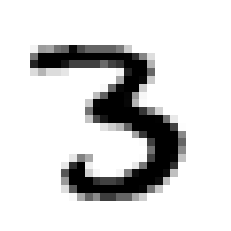

Label is: '3'


In [12]:
mnist = fetch_openml('mnist_784')
X, Y = mnist["data"], mnist["target"] # np Arrays
X = X / 255 - 0.5
i = 12
plt.imshow(X[i:i+1].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
print("Label is: '"+Y[i]+"'")

In [13]:
Y_new = DLModel.to_one_hot(10,Y)
print("New label is:", Y_new[:,i])

New label is: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


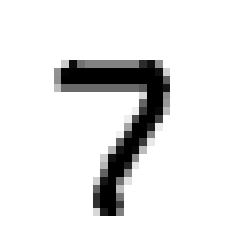

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [14]:
m = 60000
m_test = X.shape[0] - m
X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y_new[:,:m], Y_new[:,m:]
np.random.seed(111)
shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]
i = 12
plt.imshow(X_train[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
print(Y_train[:,i])

digit_network:
hidden1:
linear Function:
	learning_rate (alpha): 0.1
	Optimization: adaptive
		adaptive parameters:
			cont: 1.1
			switch: 0.5
	Parameters:
		W shape: (64, 784)
		b: (64, 1)
		num units: 64
		input size: 784
Activation function: sigmoid
output:
linear Function:
	learning_rate (alpha): 0.1
	Optimization: adaptive
		adaptive parameters:
			cont: 1.1
			switch: 0.5
	Parameters:
		W shape: (10, 64)
		b: (10, 1)
		num units: 10
		input size: 64
Activation function: softmax

digit_model
	Loss function: categorical_cross_entropy
	digit_network:
hidden1:
linear Function:
	learning_rate (alpha): 0.1
	Optimization: adaptive
		adaptive parameters:
			cont: 1.1
			switch: 0.5
	Parameters:
		W shape: (64, 784)
		b: (64, 1)
		num units: 64
		input size: 784
Activation function: sigmoid
output:
linear Function:
	learning_rate (alpha): 0.1
	Optimization: adaptive
		adaptive parameters:
			cont: 1.1
			switch: 0.5
	Parameters:
		W shape: (10, 64)
		b: (10, 1)
		num units: 10
		input si

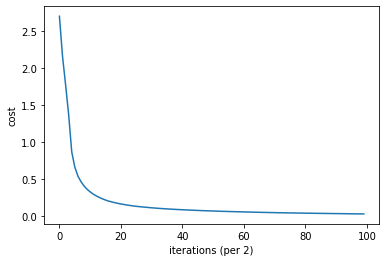

train accuracy: 99.86666666666666 %
test accuracy: 99.213 %


In [17]:
np.random.seed(1)
hidden1 = DLNeuronsLayer("hidden1",64,28*28, "sigmoid", alpha=0.1,optimization='adaptive',initialization='Xaviar')
output = DLNeuronsLayer("output",10,64, "softmax", alpha=0.1,optimization='adaptive',initialization = 'Xaviar')
digit_network = DLNetwork("digit_network")
digit_network.add(hidden1)
digit_network.add(output)
print(digit_network)

digit_model = DLModel("digit_model",digit_network,"categorical_cross_entropy")
print(digit_model)

costs = digit_model.train(X_train, Y_train,200)
u10.print_costs(costs,200)
threshold = 0.7
train_Y_hat = digit_model.forward_propagation(X_train) > threshold
print("train accuracy: {} %".format(100 - np.mean(np.abs(train_Y_hat - Y_train)) * 100))
test_Y_hat = digit_model.forward_propagation(X_test) > threshold
print("test accuracy: {} %".format(100 - np.mean(np.abs(test_Y_hat - Y_test)) * 100))
path = r'/content/drive/MyDrive/Data' ## change path to data location
digit_network.save_parameters(path)

In [18]:
path = r'/content/drive/MyDrive/Data' # change path to data location
digit_network.restore_parameters(path)
print("Train:")
digit_model.confusion_matrix(X_train, Y_train)
print("Test:")
digit_model.confusion_matrix(X_test, Y_test)

Train:
accuracy:  0.9955833333333334
[[5919    0    1    0    1    1    1    1    0    0]
 [   0 6730    2    2    4    1    0    4    0    1]
 [   0    5 5927   14    2    3    0   10    1    1]
 [   1    0    5 6078    1   18    0    2    3    4]
 [   1    0    3    0 5810    1    5    3    0    8]
 [   0    0    1   12    0 5382    0    0   12    6]
 [   0    0    0    0    3    3 5910    1    1    0]
 [   0    3   12   12    3    2    0 6237    1    9]
 [   1    4    5    7    2    5    2    2 5827    5]
 [   1    0    2    6   16    5    0    5    6 5915]]
Test:
accuracy:  0.9598
[[ 960    0    6    1    0    2    5    1    6    1]
 [   0 1113    3    2    0    0    2    3    0    4]
 [   3    2  978   11    1    6    5    9    5    0]
 [   2    4   12  967    1   14    0   10    9    6]
 [   0    1    4    1  941    2    7    4    4   18]
 [   3    2    0   12    2  847    5    3    7    7]
 [   6    2    4    0    9    6  930    0    2    1]
 [   1    5   12    6    3    3    1 

In [19]:
#Test your image
num_px = 28
img_path = r'/content/drive/MyDrive/Data/eight.jpg' # 8 img
image = Image.open(img_path)
image28 = image.resize((num_px, num_px), Image.ANTIALIAS)
gray_image = ImageOps.grayscale(image28)
my_image = np.reshape(gray_image,(num_px*num_px,1))
my_image = my_image/255 - 0.5
prediction = digit_model.forward_propagation(my_image)
print(f"prediction_index = {np.argmax(prediction, axis=0)}")


prediction_index = [7]


In [22]:
#Test your image
num_px = 28
img_path = r'/content/drive/MyDrive/Data/two.jpg' # 2 img
image = Image.open(img_path)
image28 = image.resize((num_px, num_px), Image.ANTIALIAS)
gray_image = ImageOps.grayscale(image28)
my_image = np.reshape(gray_image,(num_px*num_px,1))
my_image = my_image/255 - 0.5
prediction = digit_model.forward_propagation(my_image)
print(f"prediction_index = {np.argmax(prediction, axis=0)}")

prediction_index = [7]
